<h1>Can we find the ancestry of artificial genomes using a k-nearest neighbor algorithm trained on real data?</h1>
Here we take a first look at our data and explore using a knn model on SNPs to find the ancestry of artificial genomes.

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
superpopulation_code_colors = ['#D9EDF8', '#FFADAD', '#E4F1EE', '#FFD6A5', '#DEDAF4', '#FDFFB6']

superpopulation_code_dict = {
    'EUR': 0,
    'EAS': 1,
    'AMR': 2,
    'SAS': 3,
    'AFR': 4,
    'EUR,AFR': 5,
}

<h2> Importing data and getting an overview</h2>
Let's first look at what our data exactly looks like

In [3]:
from my_knn_module.import_data import import_genome_data_as_df

In [4]:
#real_df = import_genome_data_as_df(superpopulation_code_dict=superpopulation_code_dict)
real_df = import_genome_data_as_df(filename='65Kreal.hapt')

In [14]:
real_df.drop(real_df[real_df['Superpopulation code'] == 5].index, inplace = True)
real_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65528,65529,65530,65531,65532,65533,65534,65535,65536,Superpopulation code
0,GBR,HG00096,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,GBR,HG00096,0,1,0,0,1,1,0,0,...,1,1,0,1,1,0,0,0,1,0
2,GBR,HG00097,0,1,0,0,1,1,0,0,...,1,1,0,1,1,0,0,0,0,0
3,GBR,HG00097,0,0,0,0,1,1,0,0,...,1,0,1,1,1,0,0,0,0,0
4,GBR,HG00099,0,1,0,0,0,0,0,0,...,1,0,1,1,1,0,0,0,0,0


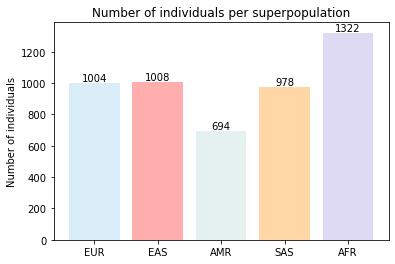

In [7]:
fig, ax = plt.subplots()

individual_per_pop = []
pop_names = ["EUR", "EAS", "AMR", "SAS", "AFR"]
for i in range(5):
    individual_per_pop.append(real_df[real_df['Superpopulation code'] == i].shape[0])

bars = ax.bar(pop_names, height=individual_per_pop, color=superpopulation_code_colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 10, yval, horizontalalignment='center')
ax.set_ylabel('Number of individuals')
ax.set_title('Number of individuals per superpopulation')

plt.show()

In [14]:
# This is our artificial genomes database, not much we can do with it right now
ag_df = pd.read_csv('./data/WGAN.hapt', delimiter = ' ')
ag_df = import_genome_data_as_df(filename='WGAN.hapt', labels=None)

<h2> Removing some data to make computing faster</h2>
We randomly sample N amounts of individuals to avoid working with the whole database.

In [15]:
SAMPLE = 1000

In [17]:
real_df = real_df.sample(n=SAMPLE).reset_index(drop=True)
ag_df = ag_df.sample(n=SAMPLE).reset_index(drop=True)

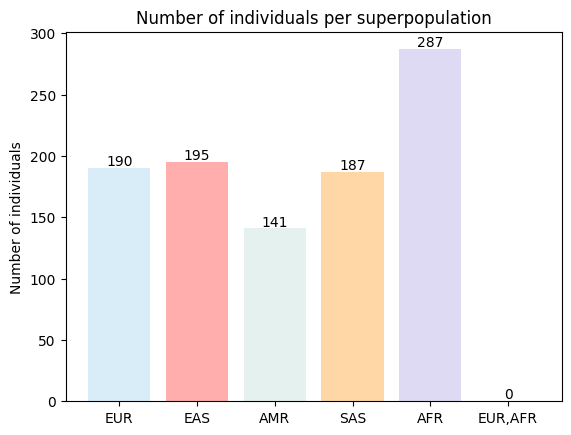

In [20]:
# Taking a look at what we have sampled
fig, ax = plt.subplots()

individual_per_pop = []
pop_names = ["EUR", "EAS", "AMR", "SAS", "AFR", "EUR,AFR"]
for i in range(6):
    individual_per_pop.append(real_df[real_df['Superpopulation code'] == i].shape[0])

bars = ax.bar(pop_names, height=individual_per_pop, color=superpopulation_code_colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 2, yval, horizontalalignment='center')
ax.set_ylabel('Number of individuals')
ax.set_title('Number of individuals per superpopulation')

plt.show()

In [23]:
NUMBER_OF_NEIGHBORS = 6
MODEL = KNeighborsClassifier

In [24]:
X = real_df.iloc[:, 3:10002]
y = np.ravel(real_df.iloc[:, 10002:10003])
knn_model = MODEL(n_neighbors = NUMBER_OF_NEIGHBORS)
knn_model.fit(X, y)

KNeighborsClassifier(n_neighbors=6)

In [27]:
train_preds = knn_model.predict(X)
mse = mean_squared_error(y, train_preds)
rmse = sqrt(mse)
print("The mean squared error for our model is: ", rmse)

The mean squared error for our model is:  0.9602083107326244


In [28]:
# Making predictions for our artificial genomes using our model
ag_preds = knn_model.predict(ag_df.iloc[:, 3:10002])
ag_df["predicted"] = ag_preds
ag_df.head()

,Type,Sample,0,1,2,3,4,5,6,7,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,predicted
0,AG,AG1825,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
1,AG,AG4948,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
2,AG,AG2472,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,AG,AG4836,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,AG,AG2414,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,3


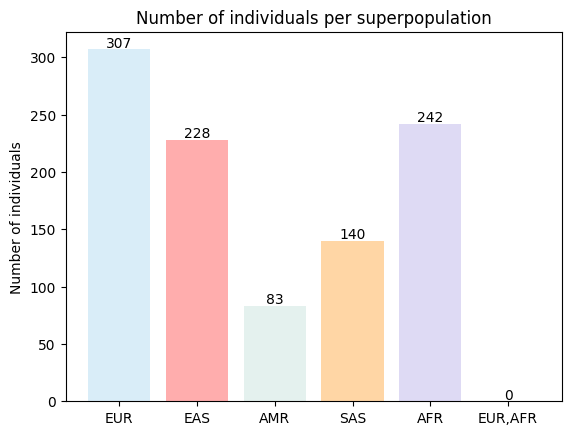

In [30]:
# Overview of our predictions
fig, ax = plt.subplots()

individual_per_pop = []
pop_names = ["EUR", "EAS", "AMR", "SAS", "AFR", "EUR,AFR"]
for i in range(6):
    individual_per_pop.append(ag_df[ag_df['predicted'] == i].shape[0])

bars = ax.bar(pop_names, height=individual_per_pop, color=superpopulation_code_colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 2, yval, horizontalalignment='center')
ax.set_ylabel('Number of individuals')
ax.set_title('Number of individuals per superpopulation')

plt.show()

In [15]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
knn_model_class = KNeighborsClassifier(n_neighbors=3)
knn_model_regressor = KNeighborsRegressor(n_neighbors=3)

knn_model_class.fit(X, y)
knn_model_regressor.fit(X, y)


/home/ghost/.local/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsRegressor(n_neighbors=3)

In [16]:
for knn_model in [knn_model_regressor, knn_model_class]:
    train_preds = knn_model.predict(X)
    mse = mean_squared_error(y, train_preds)
    rmse = sqrt(mse)
    print(rmse)

0.6280940454465817
0.8384957244209446


In [17]:
ag_preds = knn_model.predict(target_df.iloc[:, 3:10002])

In [18]:
#train_preds = np.rint(train_preds)
#ag_preds = np.rint(ag_preds)

In [19]:
target_df["predicted"] = ag_preds
target_df.head()

,Type,Sample,0,1,2,3,4,5,6,7,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,predicted
0,AG,AG0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,AG,AG1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
2,AG,AG2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,AG,AG3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,AG,AG4,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4


In [36]:
real_df["predicted"] = train_preds
real_df.head()

,Type,Sample,0,1,2,3,4,5,6,7,...,9992,9993,9994,9995,9996,9997,9998,9999,Superpopulation code,predicted
0,Real,NA11920,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
1,Real,NA19747,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,2,2
2,Real,NA19726,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,2,1
3,Real,HG01608,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Real,HG03129,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,4,4


In [21]:
#target_df['predicted'].replace({
#    0.0: 'EUR',
#    1.0: 'EAS',
#    2.0: 'AMR',
#    3.0: 'SAS',
#    4.0: 'EUR,AFR',
#    5.0: 'AFR'
#}, inplace=True)
#target_df.head()

<h2> Taking a look at our predictions projected on 2D space</h2>
Using a PCA to see what our predictions look like.

In [29]:
num_components=3
pca=PCA(n_components=num_components)

pca_result = pca.fit_transform(real_df.iloc[:, 3:65536])
#pca_targets = pca.transform(ag_df.iloc[:, 3:10002])

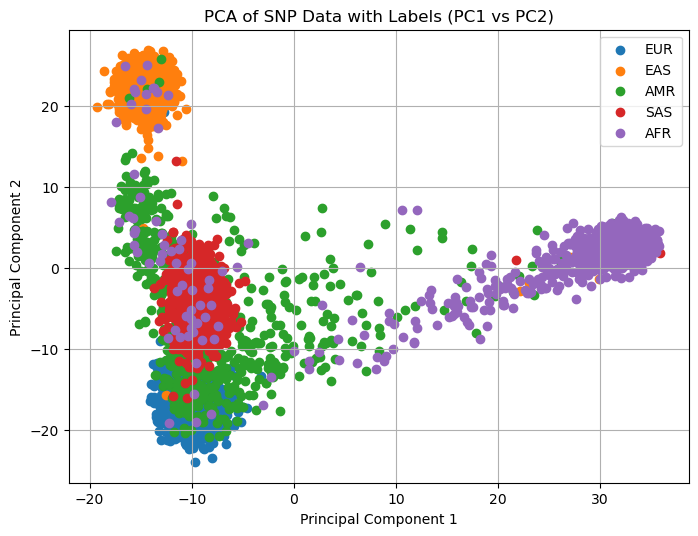

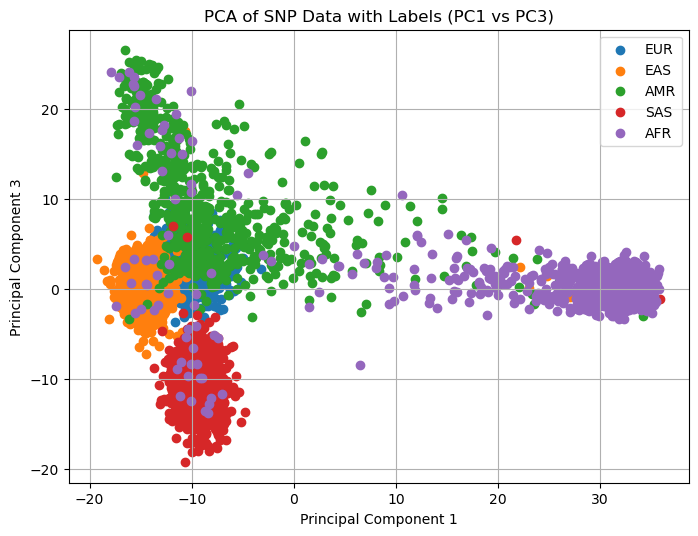

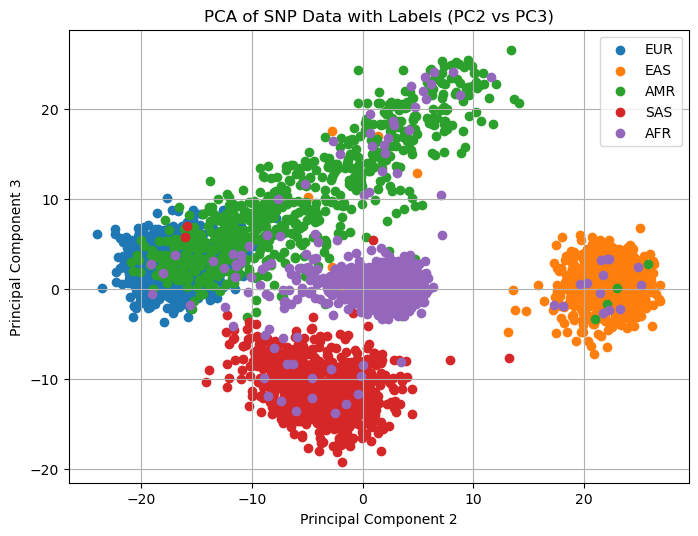

In [38]:
# Loop through each pair of principal components for plotting
for i in range(num_components):
    for j in range(i + 1, num_components):
        plt.figure(figsize=(8, 6))
        for label in real_df['Superpopulation code'].unique():
            subset = real_df[real_df['Superpopulation code'] == label]
            if label == 3: subset.drop(5006, inplace=True)
            if label == 3: subset.drop(5007, inplace=True)
            plt.scatter(pca_result[subset.index, i], pca_result[subset.index, j],
                        label = list(superpopulation_code_dict.keys())[list(superpopulation_code_dict.values()).index(label)]
            )
        
        #for label in real_df['predicted'].unique():
        #    subset = real_df[real_df['predicted'] == label]
        #    plt.scatter(pca_result[subset.index, i], pca_result[subset.index, j],
        #                label= "Predicted " + list(superpopulation_code_dict.keys())[list(superpopulation_code_dict.values()).index(label)],
        #                marker="*",
        #                color = superpopulation_code_colors[int(label)]
        #    )
        
        plt.xlabel(f'Principal Component {i+1}')
        plt.ylabel(f'Principal Component {j+1}')
        plt.title(f'PCA of SNP Data with Labels (PC{i+1} vs PC{j+1})')
        #plt.rcParams['figure.dpi'] = 100
        plt.legend()
        plt.grid(True)
        plt.show()

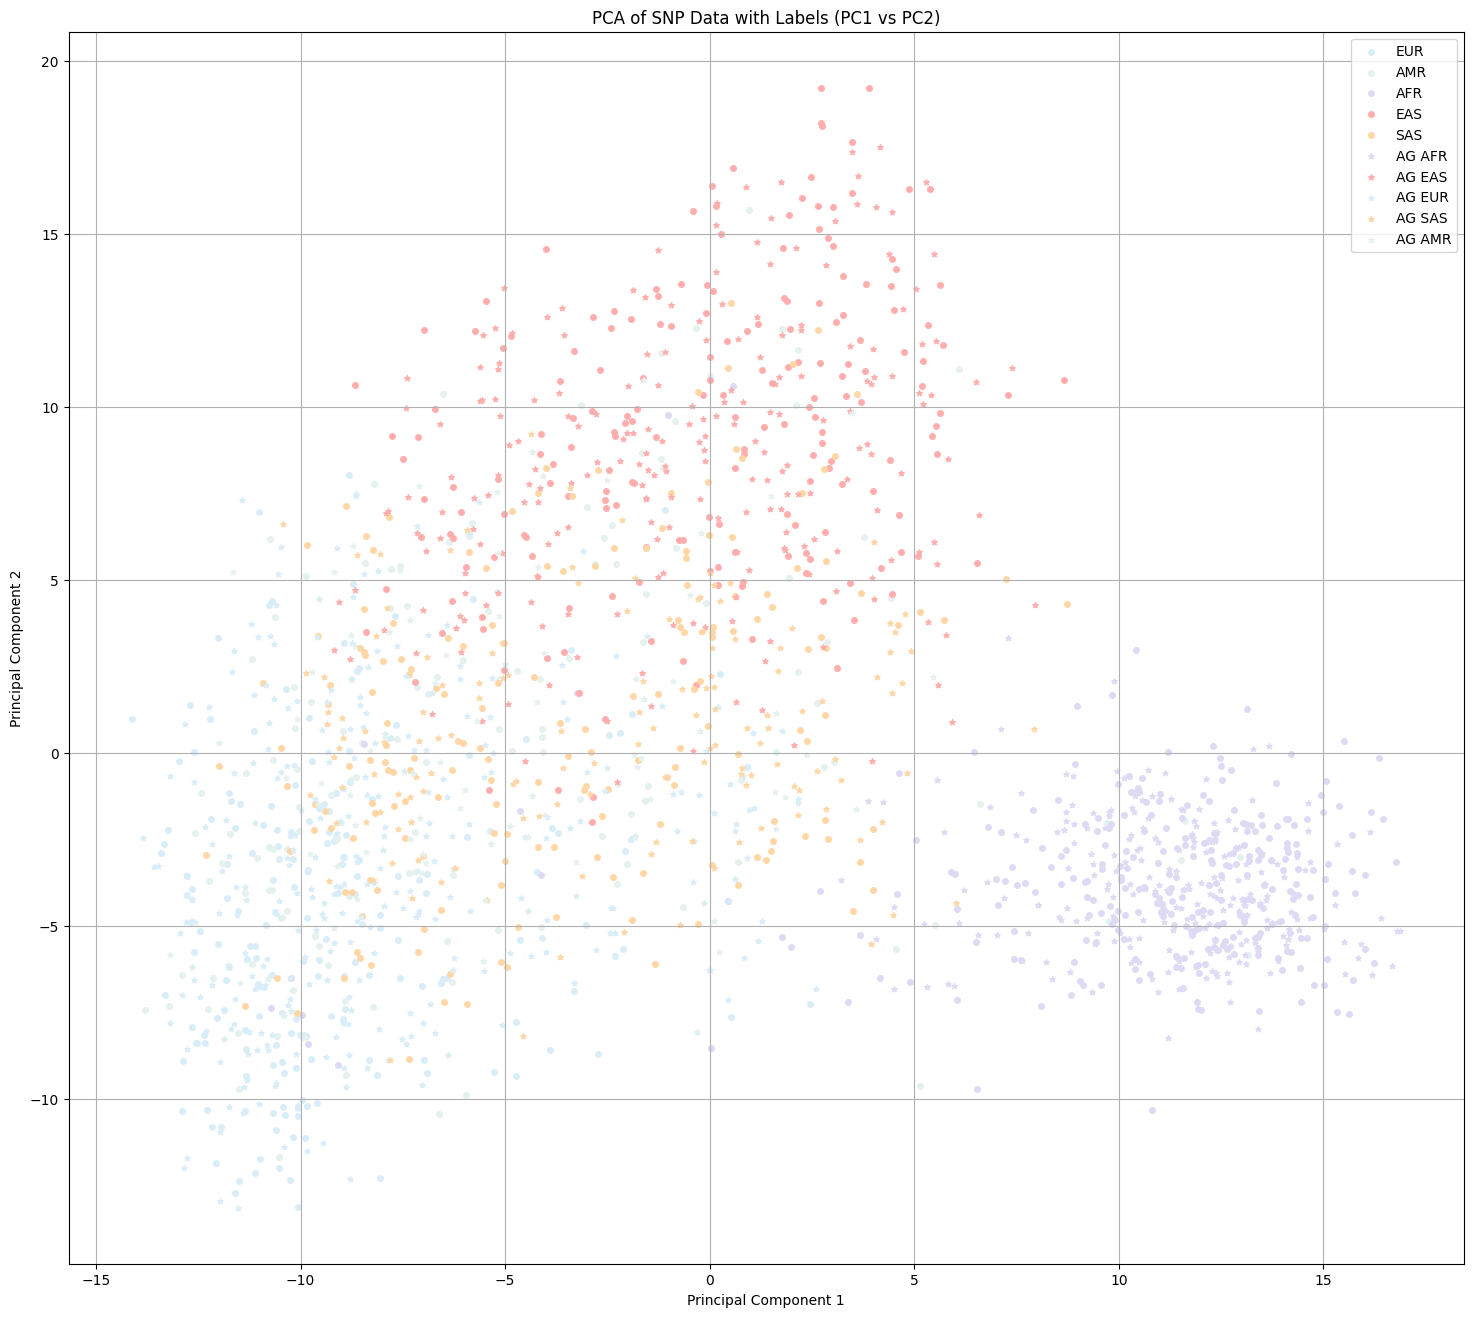

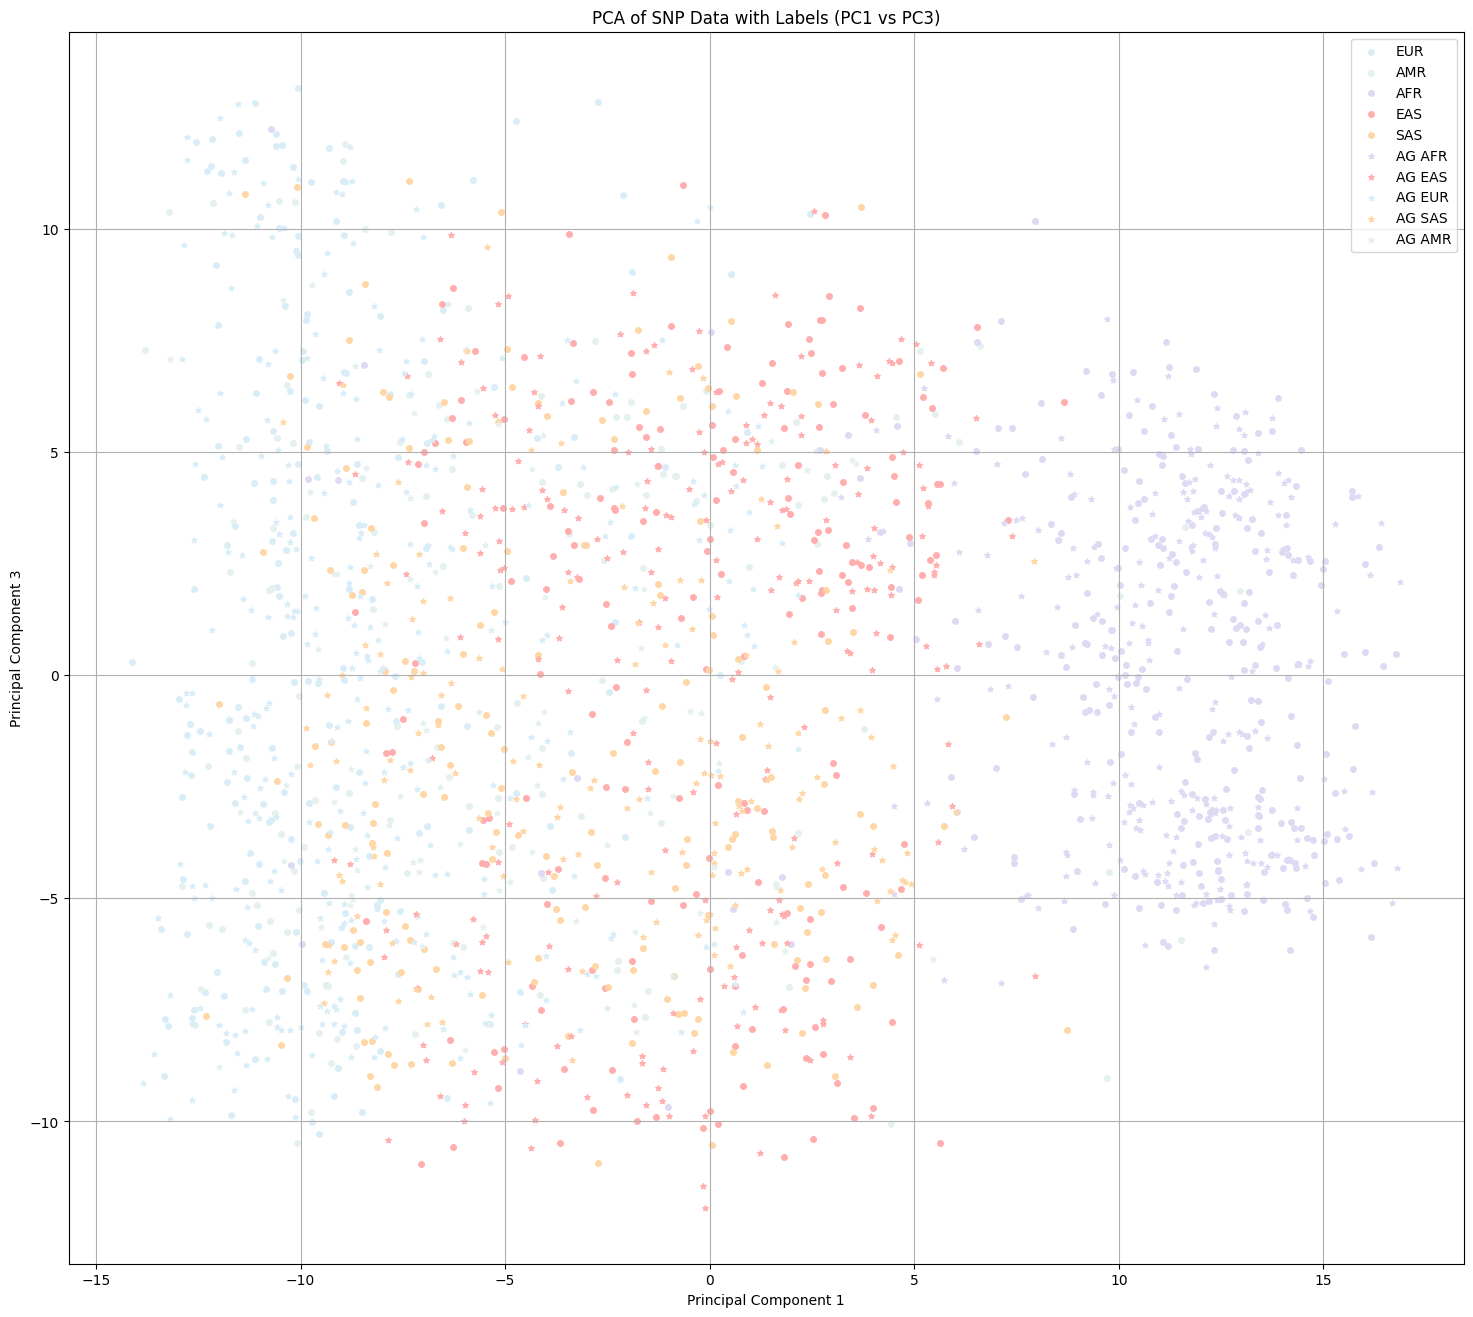

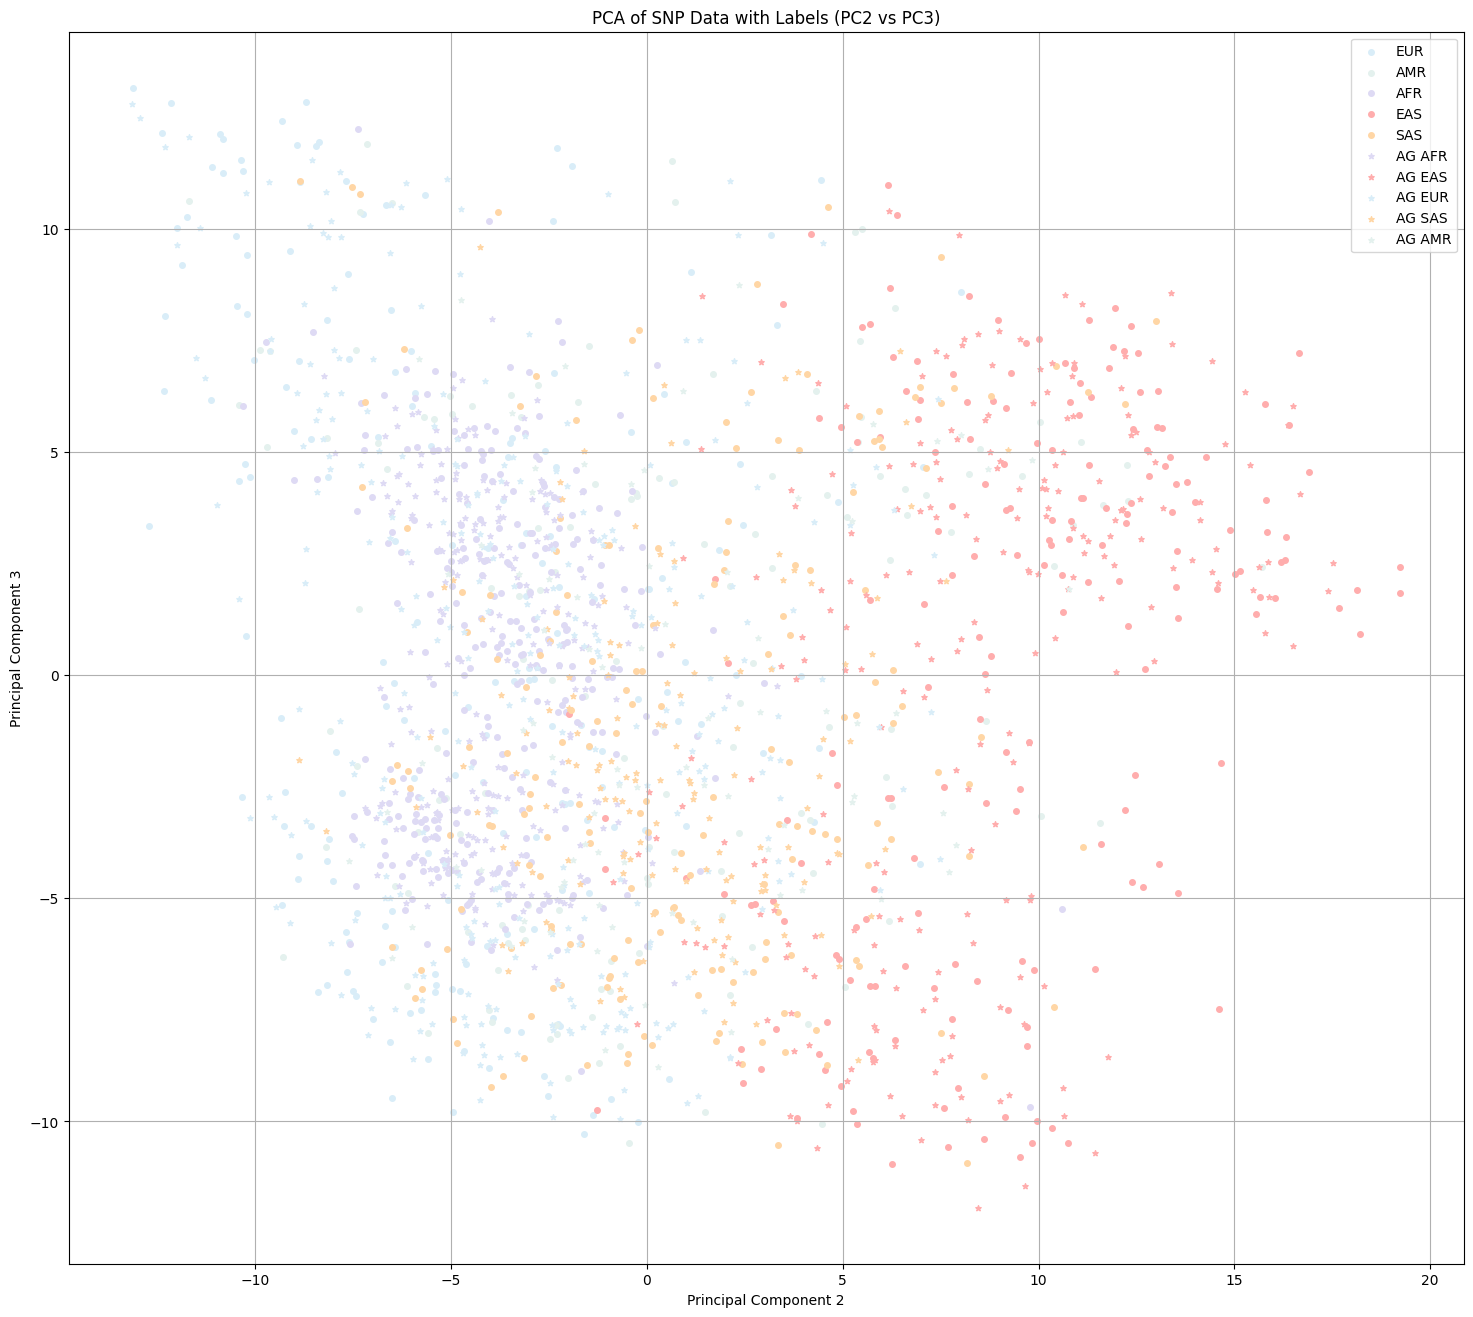

In [39]:
# Loop through each pair of principal components for plotting
for i in range(num_components):
    for j in range(i + 1, num_components):
        plt.figure(figsize=(18, 16))
        for label in real_df['Superpopulation code'].unique():
            subset = real_df[real_df['Superpopulation code'] == label]
            plt.scatter(pca_result[subset.index, i], pca_result[subset.index, j],
                        label = list(superpopulation_code_dict.keys())[list(superpopulation_code_dict.values()).index(label)],
                        color = superpopulation_code_colors[label],
                        s=16
            )
        
        for label in ag_df['predicted'].unique():
            target_subset = ag_df[ag_df['predicted'] == label]
            plt.scatter(pca_targets[target_subset.index, i], pca_targets[target_subset.index, j],
                        label= "AG " + list(superpopulation_code_dict.keys())[list(superpopulation_code_dict.values()).index(label)],
                        marker="*",
                        color = superpopulation_code_colors[int(label)],
                        s=16
            )
        
        plt.xlabel(f'Principal Component {i+1}')
        plt.ylabel(f'Principal Component {j+1}')
        plt.title(f'PCA of SNP Data with Labels (PC{i+1} vs PC{j+1})')
        plt.legend()
        plt.grid(True)
        plt.show()

# Perspective
- Voir diminution de dimension pyMDE
- Voir influence nombre de voisins paramètrage
- snp 800
